# SetFit with AzureML

### Note on Azure ML
This notebook covers how to use Azure ML to train and deploy a classifier using SetFit from with the AzureML service from Microsoft. You need an access to the Azure ML service on the [Azure portal](https://portal.azure.com/#home). 

We will use the [Python Azure Machine Learning SDK v2](https://learn.microsoft.com/en-gb/python/api/overview/azure/ai-ml-readme?view=azure-python) available with the package `azure-ai-ml`. If you were using to the v1 SDK, I suggest checking the [migration documentation](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-migrate-from-v1).

Additionally, you can check [Nate Raw's github repository](https://github.com/nateraw/azureml-pipelines) which covers preprocessing, training and deployment using Azure ML pipelines and the v1 SDK version.

If you're new to Azure ML I strongly recommend to follow the [Azure ML in a day tutorial](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-azure-ml-in-a-day) and make sure you have completed the prerequisites copied and pasted below:

**Prerequisites**

* Complete the [Quickstart: Get started with Azure Machine Learning](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources) to:

    * Create a workspace.
    
* Create a new notebook or copy our notebook.

    * Follow the Quickstart: [Run Juypter notebook in Azure Machine Learning studio](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-run-notebooks) steps to create a new notebook.
    * Or use the steps in the quickstart to [clone the v2 tutorials folder](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-run-notebooks#learn-from-sample-notebooks), then open the notebook from the tutorials/azureml-in-a-day/azureml-in-a-day.ipynb folder in your File section.
    
### Note on SetFit

*(From the [SetFit GitHub](https://github.com/huggingface/setfit/tree/main))*


SetFit is an efficient and prompt-free framework for few-shot fine-tuning of Sentence Transformers. It achieves high accuracy with little labeled data - for instance, with only 8 labeled examples per class on the Customer Reviews sentiment dataset, SetFit is competitive with fine-tuning RoBERTa Large on the full training set of 3k examples 🤯!

Compared to other few-shot learning methods, SetFit has several unique features:

* 🗣 No prompts or verbalisers: Current techniques for few-shot fine-tuning require handcrafted prompts or verbalisers to convert examples into a format that's suitable for the underlying language model. SetFit dispenses with prompts altogether by generating rich embeddings directly from text examples.
* 🏎 Fast to train: SetFit doesn't require large-scale models like T0 or GPT-3 to achieve high accuracy. As a result, it is typically an order of magnitude (or more) faster to train and run inference with.
* 🌎 Multilingual support: SetFit can be used with any Sentence Transformer on the Hub, which means you can classify text in multiple languages by simply fine-tuning a multilingual checkpoint.

### Install Dependencies 

In [239]:
#!pip install azure-ai-ml --upgrade #Azure ML sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 41.6 MB/s eta 0:00:00a 0:00:01


  Attempting uninstall: azure-ai-ml
    Found existing installation: azure-ai-ml 1.1.0
    Uninstalling azure-ai-ml-1.1.0:
      Successfully uninstalled azure-ai-ml-1.1.0


In [273]:
!pip install azure-identity --upgrade #Azure identity sdk

In [274]:
!pip install azure-keyvault-secrets --upgrade #Connect to your keyvault

In [275]:
!pip install azure-core --upgrade

In [ ]:
!pip install python-dotenv #Set environment variables

In [101]:
import pyarrow

In [104]:
pyarrow.__version__

'9.0.0'

### Create a workspace

As mentioned in the *prerequisites* you should have created a workspace following [this article](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources)

### Log into Azure using the CLI

The Azure CLI allows you to use the Azure resources from the command line:
* [Install the CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli)
* [Learn to use the CLI with Azure ML](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-cli?tabs=public)

Once installed you can log into your Azure using the following command:

In [193]:
!az login 

### Create a Key Vault

You should have created an Azure ML **workspace** on the portal. 

Your training loop will need to have access to the Hugging Face Hub to fetch models or dataset (potentially private) stored on the platform. The 🤗 Hub uses [user access tokens](https://huggingface.co/docs/hub/security-tokens) to grant permissions to a model or a dataset.You can create a new token that will be used in your Azure applications in your [profile settings](https://huggingface.co/settings/tokens) <div>
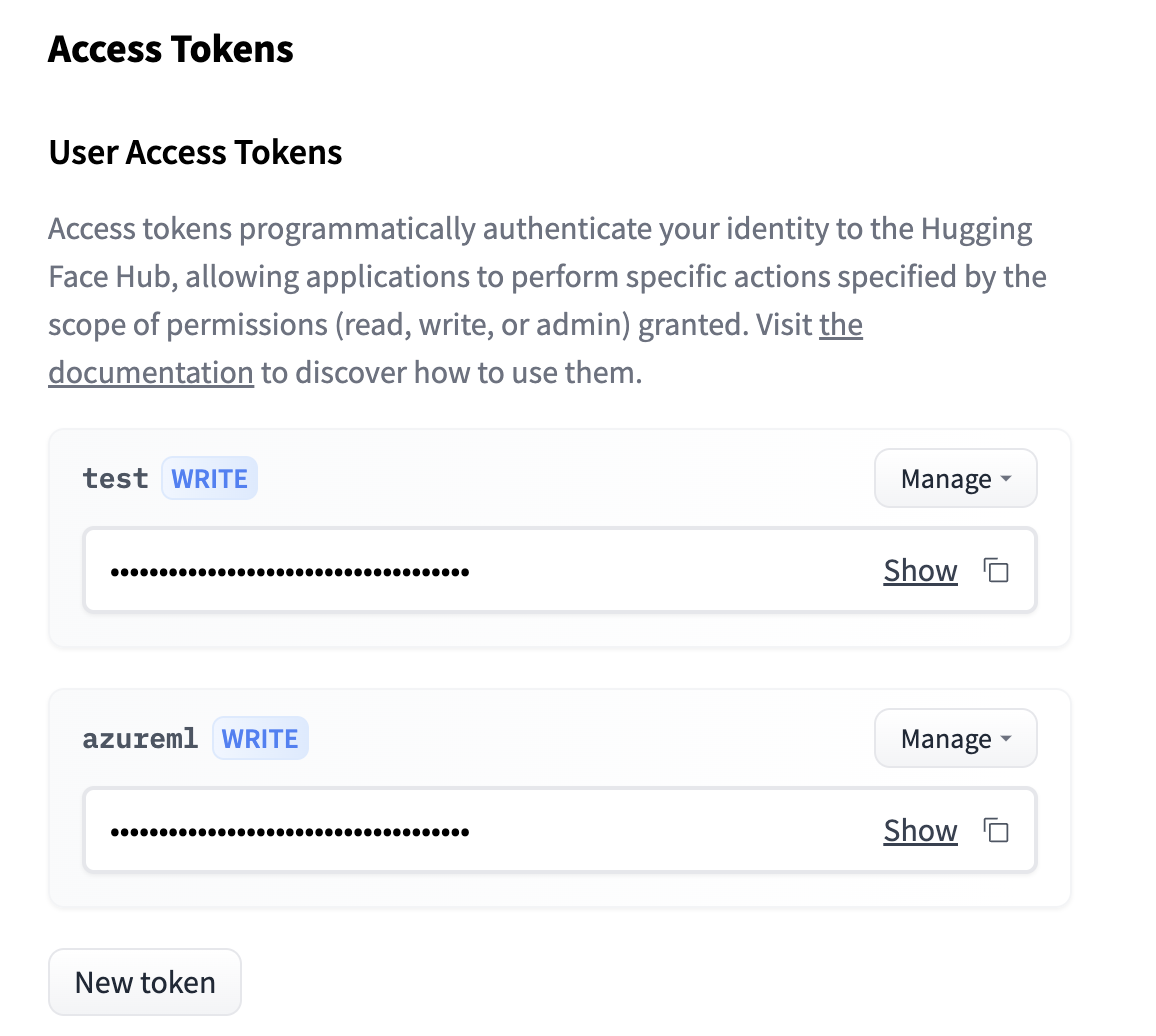
    
However, you don't want to copy and paste this token in the script files that will train your model. This token should be stored in a secure location in your Azure environnement that will be accessed during training by the instance you will used. That secure location can be a **Key Vault**. To learn more about key vaults, check out [the documentation](https://learn.microsoft.com/en-us/azure/key-vault/general/overview). 
    
You can create a Key Vault directly from the portal ([see](https://learn.microsoft.com/en-us/azure/key-vault/general/quick-create-portal)) or using the CLI running the following command:

In [ ]:
!az keyvault create --name "<your-unique-keyvault-name>" --resource-group "<myResourceGroup>" --location "EastUS"

To add your `hf-token` secret to your key vault now you should run (or alternatively [from the portal](https://learn.microsoft.com/en-us/azure/key-vault/secrets/quick-create-portal?source=recommendations)):

In [ ]:
!az keyvault secret set --vault-name "<your-unique-keyvault-name>" --name "hf-token" --value "hf_XXXXXXXXXX"

Now you are ready to retrieve your `hf-token` from your Azure applications

### Authentication 

In your workspace, you can now create resources, such as compute resources. In order to access them authentication methods need to be set up properly. 

You've already authenticated this notebook as a *user* previously using the CLI. But if your code is running outside of this notebook in an automated process that doesn't require user interaction, you will also need to set up authentication for that app. In addition, the compute instance you'll use for training will need to fetch the `hf-token` from the key vault and therefore needs to be authenticated.

Azure uses [role-based access control (RBAC)](https://learn.microsoft.com/en-us/azure/role-based-access-control/overview) to determine the level of access to a given resource.

Consult [AzureML tutorial on authentication](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk) to learn more. 

In this example, we will show how to authenticate:
* as a user using the ***Azure CLI***
* as ***Service Principal*** for automated process authentication
* using ***Managed Identity***, for resources created in your Azure Active Directory to access other Azure resources. We will later see how to set up *Managed Identity* for the *compute cluster* you will for training. You can also refer to the [attached article](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-identity-based-service-authentication?tabs=python#compute-cluster)

#### Using a Azure CLI

**1. Authenticate**

Just run as in the precedent section

In [ ]:
!az login 

**2. Grant access to the Key Vault using the CLI ([ref](https://learn.microsoft.com/en-us/azure/key-vault/general/rbac-guide?tabs=azure-cli))**: 

We will grant the user (your e-mail address) access to the previously created key vault `<your-unique-keyvault-name>` the role `Key Vault Administrator` to be able to consult secrets when logged in as a user. 

In [203]:
%%bash
az role assignment create --role "Key Vault Administrator" \
--assignee <your-email@microsoft.com> \
--scope /subscriptions/"<your-subscription-id>"/resourceGroups/"<myResourceGroup>"/providers/Microsoft.KeyVault/vaults/"<your-unique-keyvault-name>"

#### Using a Service Principal
*You don't need to follow the steps below if you're already authenticated on this notebook using the CLI*

**1. Create the Service Principal**

To authenticate an automated process in charge of launching the training on your workspace or deploying the model you'll have to create a ***Service Principal*** with the appropriate role. 

Run the following to create a service principal with contributor access to the resource group where your AzureML workspace resides (replace the values in angle brackets with your own values - to retrieve your `subscription-id` check out [this article](https://learn.microsoft.com/en-us/azure/azure-portal/get-subscription-tenant-id))

In [ ]:
%%bash
az ad sp create-for-rbac --name <service-principal-name> 
--role Contributor 
--scopes /subscriptions/<subscription-id>/resourceGroups/machinelearning 
--sdk-auth

The previous command will output a dictonnary with the keys `clientId`, `clientSecret` and `tenantId` of which the values should be set as environment variables.

You can easily define environment variables using the package `python-dotenv`installed previously. This is what is recommended by Azure in the [tutorial on authentication](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk#use-service-principal-authentication).

Now you should define a `.env` with those environment variables

In [ ]:
%%writefile .env
AZURE_CLIENT_ID=<clientId>
AZURE_TENANT_ID=<tenantId>
AZURE_CLIENT_SECRET=<clientSecret>

Running the following lines in your code will set the environment variables from the `.env`file

In [2]:
%load_ext dotenv #add those line magic in jupyter notebook only 
%dotenv -o

from dotenv import load_dotenv
load_dotenv() 

**2. Grant access to the Key Vault using the CLI ([ref](https://learn.microsoft.com/en-us/azure/key-vault/general/rbac-guide?tabs=azure-cli))**: 

To get the id of the service principal `<service-principal-name>` you created previously, run:

In [223]:
%%bash
az ad sp list --all --query "[?displayName=='<service-principal-name>'].{displayName:displayName, id:id}" 

[
  {
    "displayName": "flo-auth",
    "id": "2895772e-70c0-4d0e-94f8-f7de273f9785"
  }
]


Then run:

In [ ]:
%%bash
az role assignment create --role "Key Vault Administrator" \
--assignee <id-from-previous-command> \
--scope /subscriptions/"<your-subscription-id>"/resourceGroups/"<myResourceGroup>"/providers/Microsoft.KeyVault/vaults/"<your-unique-keyvault-name>"

#### Using Managed Identity

Managed identities are keys used by Azure resources (such as VM, compute clusters, etc.) to access other resources which lie into the same Azure Active Directory. [Learn more.](https://learn.microsoft.com/en-us/azure/active-directory/managed-identities-azure-resources/overview) 

We will use one managed identity with granted access to our key vault assign it to our compute cluster so it can fetch the `hf-token` securely.

**1. Create the Managed Identity**

In [ ]:
!az identity create --name "<managed-identity-name>" --resource-group "<myResourceGroup>"

**2. Grant access to the Key Vault using the CLI ([ref](https://learn.microsoft.com/en-us/azure/key-vault/general/rbac-guide?tabs=azure-cli))**: 

To get the id of the service principal `<managed-identity-name>` you created previously, run:

In [226]:
%%bash
az ad sp list --all --query "[?displayName=='<managed-identity-name>'].{displayName:displayName, id:id}" 

[
  {
    "displayName": "flo-test-mi",
    "id": "a4a943ff-f5ac-47c0-a5ac-2274113d13ed"
  }
]


Then run:

In [ ]:
%%bash
az role assignment create --role "Key Vault Administrator" \
--assignee <id-from-previous-command> \
--scope /subscriptions/"<your-subscription-id>"/resourceGroups/"<myResourceGroup>"/providers/Microsoft.KeyVault/vaults/"<your-unique-keyvault-name>"

### Connect to the workspace

* If you are authenticated using the Azure CLI run:

In [230]:
# Authentication package
from azure.identity import AzureCliCredential
credential = AzureCliCredential()


* If you are authenticated using a service principal run:

In [20]:
# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

* Run the following line to make sure you are authenticated properly:

In [22]:
credential.get_token("https://management.azure.com/.default")

AccessToken(token='eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6IjJaUXBKM1VwYmpBWVhZR2FYRUpsOGxWMFRPSSIsImtpZCI6IjJaUXBKM1VwYmpBWVhZR2FYRUpsOGxWMFRPSSJ9.eyJhdWQiOiJodHRwczovL21hbmFnZW1lbnQuYXp1cmUuY29tIiwiaXNzIjoiaHR0cHM6Ly9zdHMud2luZG93cy5uZXQvZjQwYjE4YmEtYjY2Yy00OWU0LTlmZDgtNGZjN2QzZDE5ZjBmLyIsImlhdCI6MTY2OTI4MTY1MCwibmJmIjoxNjY5MjgxNjUwLCJleHAiOjE2NjkyODU1NTAsImFpbyI6IkUyWmdZTGhyZktqemhZMTkvczc3WEZ4WHV6Ui9BZ0E9IiwiYXBwaWQiOiJiNmRmODU1Ni1kMWJiLTRiNDEtYTBlNC02YWQ3OTFiZDk4YjgiLCJhcHBpZGFjciI6IjEiLCJpZHAiOiJodHRwczovL3N0cy53aW5kb3dzLm5ldC9mNDBiMThiYS1iNjZjLTQ5ZTQtOWZkOC00ZmM3ZDNkMTlmMGYvIiwiaWR0eXAiOiJhcHAiLCJvaWQiOiIyODk1NzcyZS03MGMwLTRkMGUtOTRmOC1mN2RlMjczZjk3ODUiLCJyaCI6IjAuQVhZQXVoZ0w5R3kyNUVtZjJFX0gwOUdmRDBaSWYza0F1dGRQdWtQYXdmajJNQk4yQUFBLiIsInN1YiI6IjI4OTU3NzJlLTcwYzAtNGQwZS05NGY4LWY3ZGUyNzNmOTc4NSIsInRpZCI6ImY0MGIxOGJhLWI2NmMtNDllNC05ZmQ4LTRmYzdkM2QxOWYwZiIsInV0aSI6IkdBODhHRlgtMzAyUXdGQVBlQV8xQUEiLCJ2ZXIiOiIxLjAiLCJ4bXNfY2MiOlsiQ1AxIl0sInhtc190Y2R0IjoxNTAwMzcwODYwfQ.aGJT7iiWf7lcF

* Check that you can access your key vault secret ([learn more](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-secrets-in-runs)):

In [231]:
# Key Vault handler package
from azure.keyvault.secrets import SecretClient

In [232]:
secret_client = SecretClient(
    vault_url="https://<my-unique-keyvault-name>.vault.azure.net/", 
    credential=credential
)

If the next cell runs properly you're fine 🤗

In [234]:
hf_token = secret_client.get_secret("hf-token")

In [276]:
print(hf_token.value)

> In the next cell, enter your Subscription ID, Resource Group name and Workspace name. To find these values: 
> 1. In the upper right Azure Machine Learning studio toolbar, select your workspace name.
> 2. Copy the value for workspace, resource group and subscription ID into the code.
> 3. You'll need to copy one value, close the area and paste, then come back for the next one.

In [ ]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="<my-subscription-id>",
    resource_group_name="<myResourceGroup>",
    workspace_name="<my-workspace>",
)

### Create a compute resource to run your job

> You'll need a compute resource for running a job. It can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark.

> You'll provision a Linux compute cluster. See the full list on [VM sizes and prices](https://azure.microsoft.com/en-gb/pricing/details/machine-learning/) .

For this example, you only need a cluster with a GPU, so you'll use a Standard_NC6 model with 6 vCPU cores, 56-GB RAM and 1 Nvidia K80 GPU. You'll also need to assign the previously created `<managed-identity-name>` to the cluster [(learn more)](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-identity-based-service-authentication?tabs=python#compute-cluster).

In [265]:
from azure.ai.ml.entities import ManagedIdentityConfiguration, IdentityConfiguration, AmlCompute
from azure.ai.ml.constants._compute import IdentityType

# Create an identity configuration from the user-assigned managed identity
managed_identity = ManagedIdentityConfiguration(
    resource_id=f"/subscriptions/<my-subscription-id>/resourcegroups/<myResourceGroup>/providers/Microsoft.ManagedIdentity/userAssignedIdentities/<managed-identity-name>")

identity_config = IdentityConfiguration(
    type = IdentityType.MANAGED_IDENTITY, 
    user_assigned_identities=[managed_identity]
)

gpu_compute_target = "<myClusterName>"

try:
    # let's see if the compute target already exists
    gpu_cluster = ml_client.compute.get(gpu_compute_target)
    print(
        f"You already have a cluster named {gpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new gpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    gpu_cluster = AmlCompute(
        # Name assigned to the compute cluster
        name=gpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_NC6",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
        # Managed identity assigned
        identity=identity_config
    )

    # Now, we pass the object to MLClient's create_or_update method
    gpu_cluster = ml_client.begin_create_or_update(gpu_cluster).result()

print(
    f"AMLCompute with name {gpu_cluster.name} is created, the compute size is {gpu_cluster.size}"
)

You already have a cluster named gpu-cluster, we'll reuse it as is.
AMLCompute with name gpu-cluster is created, the compute size is STANDARD_NC6


### Create a job environment

>To run your AzureML job on your compute resource, you'll need an [environment](https://learn.microsoft.com/en-us/azure/machine-learning/concept-environments). An environment lists the software runtime and libraries that you want installed on the compute where you’ll be training. It's similar to your python environment on your local machine.

>AzureML provides many curated or ready-made environments, which are useful for common training and inference scenarios. You can also create your own custom environments using a docker image, or a conda configuration.

>In this example, you'll create a custom conda environment for your jobs, using a conda yaml file.

>First, create a directory to store the file in.

In [25]:
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

Now, create the file in the dependencies directory.

In [159]:
%%writefile {dependencies_dir}/conda.yml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.9
  - numpy
  - pip
  - scikit-learn
  - scipy
  - pandas
  - pip:
    - pyarrow==9.0.0
    - azure-identity>=1.8.0
    - transformers==4.21.2
    - azure-ai-ml
    - datasets==2.3.2
    - torch==1.12.1
    - tensorboard
    - mlflow 
    - setfit
    - azure-keyvault-secrets
    - azureml-mlflow
    - xlrd
    - mlflow
    - psutil
    - tqdm
    - ipykernel
    - matplotlib
    - opencensus
    - opencensus-ext-azure
    - inference-schema[numpy-support]

Overwriting ./dependencies/conda.yml


The environment is created from a pre-existing docker image `mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest`which has already pre-built dependencies such as `cuda`. To check the list of available container images visit: [AzureML-Containers](https://github.com/Azure/AzureML-Containers)

The specification contains some usual packages, that you'll use in your job (numpy, pip, transformers, datasets).

Reference this yaml file to create and register this custom environment in your workspace:

In [160]:
from azure.ai.ml.entities import Environment

custom_env_name = "aml-transformers-setfit"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for SetFit training",
    tags={"transformers": "4.21.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
)


pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)


print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

Environment with name aml-transformers-setfit is registered to workspace, the environment version is 30


### What is a command job?

>You'll create an Azure ML ***command job*** to train a setfit model for text classification. The command job is used to run a training script in a specified environment on a specified compute resource. You've already created the environment and the compute resource. Next you'll create the training script.

>The ***training script*** handles the data preparation, training and registering of the trained model. In this tutorial, you'll create a Python training script.

>Command jobs can be run from CLI, Python SDK, or studio interface. In this tutorial, you'll use the Azure ML Python SDK v2 to create and run the command job.

>After running the training job, you'll deploy the model, then use it to produce a prediction.


### Create training script

Let's start by creating the training script - the `train_setfit.py` python file.

First create a source folder `./src` for the script:

In [123]:
train_src_dir = "./src"
os.makedirs(train_src_dir, exist_ok=True)

The script:
1. Loads dataset from the [Hugging Face Hub](hf.co)
2. Preprocesses the dataset
3. Loads a `SetFitTrainer` with a specified `model_name`
4. Trains SetFit model
5. Logs training and evaluation metrics with MLFlow ([learn more](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-mlflow-cli-runs?tabs=azuremlsdk))
6. Saves the model in an output directory

In [169]:
%%writefile {train_src_dir}/train_setfit.py

import os

import mlflow
import argparse

from setfit import SetFitModel, SetFitTrainer
from datasets import load_dataset, Dataset
from sentence_transformers.losses import CosineSimilarityLoss, BatchHardTripletLoss

from azure.identity import DefaultAzureCredential,ManagedIdentityCredential
from azure.keyvault.secrets import SecretClient


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, help="dataset in HF Hub")
    parser.add_argument("--output_dir", type=str, required=False, default=".outputs/")
    parser.add_argument("--model_name", type=str, required=False, default="sentence-transformers/all-mpnet-base-v2")
    parser.add_argument("--keyvault_name", type=str, required=False, default="<my-unique-keyvault-name>")
    parser.add_argument("--batch_size", required=False, default=16, type=int)

    
    args = parser.parse_args()
    
    #Configure Managed Identity to retrieve token secret
    client_id = os.environ.get('DEFAULT_IDENTITY_CLIENT_ID')
    credential = ManagedIdentityCredential(client_id=client_id)
    token = credential.get_token('https://storage.azure.com/')
    secret_client = SecretClient(
        vault_url=f"https://{args.keyvault_name}.vault.azure.net/", 
        credential=credential
    )
    
    # Start Logging
    mlflow.autolog()
    with mlflow.start_run() as run:

        ###################
        #<prepare the data>
        ###################
        
        print(" ".join(f"{k}={v}" for k, v in vars(args).items()))
        #Load dataset from HF Hub
        dataset = load_dataset(args.dataset_name, use_auth_token=secret_client.get_secret("hf-token").value)
        df = dataset["train"].to_pandas()
        df_train = df[df["purpose"]=="train"]
        df_train = df_train[["label", "sentence", "word"]]
        #create a subset of dataframe 
        df_train=df_train.loc[:, 'label':'sentence']
        df_train = df_train.reset_index(drop=True)
        df_train = Dataset.from_pandas(df_train)

        # test data
        df_test = df[df["purpose"]=="test"]
        df_test = df_test[["label", "sentence", "word"]]
        #create a subset of dataframe 
        df_test = df_test.loc[:, 'label':'sentence']
        df_test = df_test.reset_index(drop=True)
        df_test = Dataset.from_pandas(df_test)
        ###################
        # <load model>
        ###################
        model = SetFitModel.from_pretrained(args.model_name)
        trainer = SetFitTrainer(
            model=model,
            train_dataset=df_train,
            eval_dataset=df_test,
            loss_class=CosineSimilarityLoss,
            batch_size=args.batch_size,
            num_epochs=1,
            num_iterations=20,
            column_mapping={"sentence": "text", "label": "label"},
        )
        #####################
        # <train & evaluate>
        #####################
        trainer.train()
        metrics = trainer.evaluate()
        ########################
        # <save model & metrics>
        ########################
        mlflow.log_metrics(metrics)
        trainer.model.save_pretrained(args.output_dir)

    
if __name__ == "__main__":
    main()


Overwriting ./src/train_setfit.py


### Configure the command

>Now that you have a script that can perform the desired tasks, you'll use the general purpose command that can run command line actions. This command line action can be directly calling system commands or by running a script.

>Here, you'll create input variables to specify the input data, batch size, encoder name and registered model name. The command script will:

> 1. Use the compute created earlier to run this command.

>2. Use the environment created earlier - you can use the `@latest` notation to indicate the latest version of the environment when the command is run.

>3. Configure some metadata like display name, experiment name etc. An experiment is a container for all the iterations you do on a certain project. All the jobs submitted under the same experiment name would be listed next to each other in Azure ML studio.

>4. Configure the command line action itself - `python train_setfit.py` in this case. The inputs/outputs are accessible in the command via the `${{ ... }}` notation.

In [ ]:
experiment_name = "train_model_setfit" #name of all iterations of my project
display_name = "inclusivity_training" #name of the job 

In [170]:
from azure.ai.ml import command

job = command(
    inputs=dict(
        dataset_name="witty-works/fossil_flex",
        keyvault_name = "<my-unique-keyvault-name>"
        
    ),
    code="./src/", 
    command="python train_setfit.py --dataset_name ${{inputs.dataset_name}} --keyvault_name ${{inputs.keyvault_name}} ",
    environment="aml-transformers-setfit@latest",
    compute=gpu_compute_target,
    experiment_name=experiment_name,
    display_name=display_name,
)

In [ ]:
command?

### Submit the job

>It's now time to submit the job to run in AzureML. This time you'll use `create_or_update` on `ml_client.jobs`.

In [171]:
ml_client.create_or_update(job)


Uploading src (0.01 MBs): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9870/9870 [00:00<00:00, 26530.03it/s]




Experiment,Name,Type,Status,Details Page
train_model_setfit,frosty_corn_v2zmb8bmnr,command,Starting,Link to Azure Machine Learning studio


### View job output and wait for job completion

View the job in AzureML studio by selecting the link in the output of the previous cell.

The output of this job will look like this in the AzureML studio. Explore the tabs for various details like metrics, outputs etc. Once completed, the job will register a model in your workspace as a result of training.

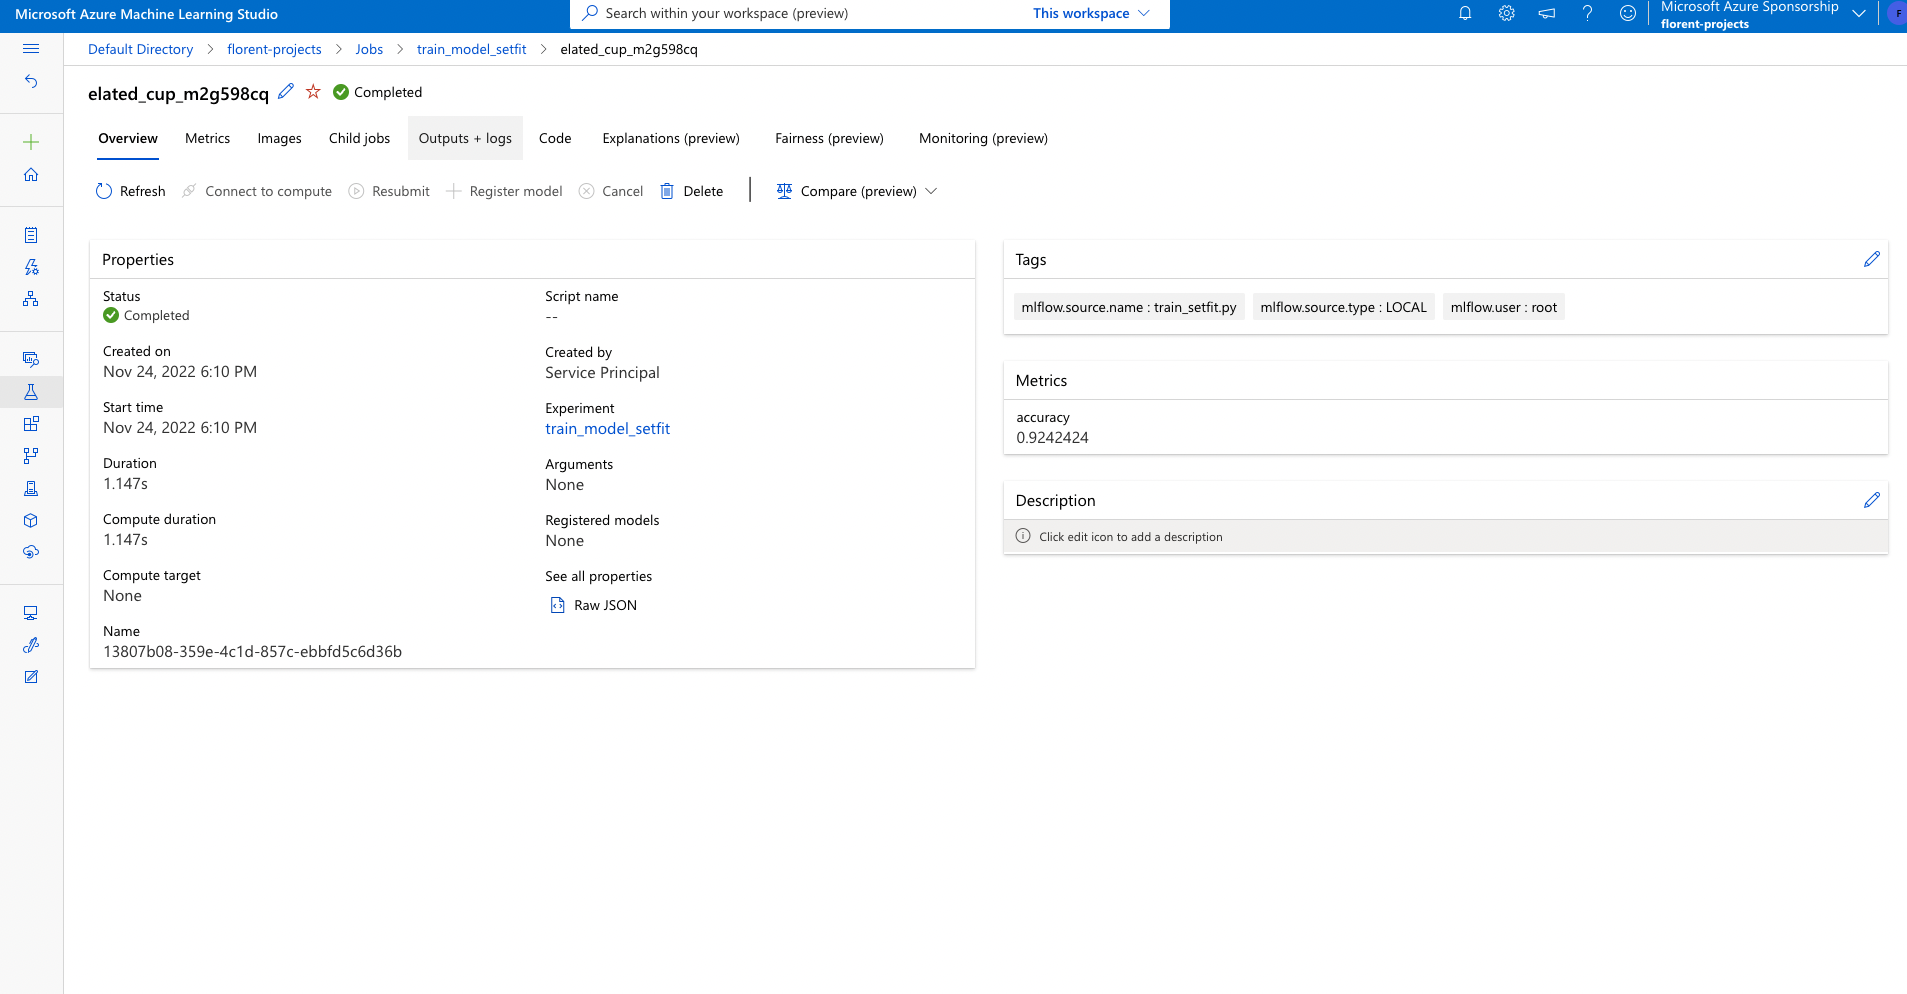

### Register your model as an asset

The Setfit model has been saved to the `output_dir`, `outputs/`  you specified when launching the job. To deploy an endpoint with that model you need to saved the artefacts of the trained model as a new ***Azure ML Model***. This can be done either using the CLI or the Web UI. [Follow the guide](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models?tabs=use-job-output%2Ccli#tabpanel_2_use-job-output) for more information.

In [168]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import ModelType

run_model = Model(
    path="""
    azureml://subscriptions/<my-subscription-id>/resourcegroups/<myResourceGroup>/<myWorkspaceName>/datastores/workspaceartifactstore/paths/ExperimentRun/dcid.<JobId (get it from output of job cell)>/outputs/model
    """,
    name="<myModelname",
    description="Model created from run.",
    type="custom_model"
)

ml_client.models.create_or_update(run_model) 

Model({'job_name': None, 'is_anonymous': False, 'auto_increment_version': False, 'name': 'run-model-example', 'description': 'Model created from run.', 'tags': {}, 'properties': {}, 'id': '/subscriptions/d5210851-d1ca-44ac-8071-a0c7191e9631/resourceGroups/machinelearning/providers/Microsoft.MachineLearningServices/workspaces/florent-projects/models/run-model-example/versions/25', 'Resource__source_path': None, 'base_path': '/home/florent_huggingface_co/repos/azure_ml', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f173ff00f10>, 'serialize': <msrest.serialization.Serializer object at 0x7f17161e6100>, 'version': '25', 'latest_version': None, 'path': 'azureml://subscriptions/d5210851-d1ca-44ac-8071-a0c7191e9631/resourceGroups/machinelearning/workspaces/florent-projects/datastores/workspaceartifactstore/paths/ExperimentRun/dcid.cool_car_wg4kq53cxj/outputs/model', 'datastore': None, 'utc_time_created': None, 'flavors': None, 'arm_type': 'model_version', 'typ

### Deploy the model as an online endpoint

#### Understand the scoring script

To perform inference, you have to write a scoring script that will indicate how the model should be loaded by your endpoint and how inference should be performed.

Check out the [GitHub repository](https://github.com/Azure/azureml-examples/blob/main/sdk/python/endpoints/online/model-1/onlinescoring/score.py) for example scoring scripts.

Your scoring script `score.py`must have an `init()` function and a `run()` function. 

> The `init()` function is called when the container is initialized or started. Initialization typically occurs
> shortly after the deployment is created or updated. Write logic here for global initialization operations like 
> caching the model in memory (as we do in this example). The `run()` function is called for every invocation of 
> the endpoint and should do the actual scoring and prediction. In the example, we extract the data from the JSON > input, call the SetFit model forward pass, and then return the result.

In [100]:
%%writefile {train_src_dir}/score.py

import os
import logging
import json
import transformers
from setfit import SetFitModel



def init():
    """
    This function is called when the container is initialized/started, typically after create/update of the deployment.
    You can write the logic here to perform init operations like caching the model in memory
    """
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    print(os.getenv("AZUREML_MODEL_DIR"))
    model = SetFitModel.from_pretrained(os.path.join(os.getenv("AZUREML_MODEL_DIR"), "model"))
    logging.info("Init complete")


def run(raw_data):
    """
    This function is called for every invocation of the endpoint to perform the actual scoring/prediction.
    In the example we extract the data from the json input and call the scikit-learn model's predict()
    method and return the result back
    """
    logging.info("Request received")
    data = json.loads(raw_data)["data"]

    result = model([data])
    logging.info("Request processed")
    return str(result[0])

Overwriting ./src/score.py


#### Create a new online endpoint

Now that you have a registered model and an inference script, it's time to create your online endpoint. The endpoint name needs to be unique in the entire Azure region. For this tutorial, you'll create a unique name using UUID.

In [ ]:
import uuid

# Creating a unique name for the endpoint
online_endpoint_name = "setfit-endpoint-" + str(uuid.uuid4())[:8]

In [ ]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
  name=online_endpoint_name, description="this is a sample local endpoint"
)

In [ ]:
ml_client.online_endpoints.begin_create_or_update(endpoint)

#### Deploy the model to the endpoint

Here you select the environment and the instance type on which you want to have your deployment. For the list of accessible VMs consult [this article](#https://learn.microsoft.com/en-us/azure/machine-learning/reference-managed-online-endpoints-vm-sku-list).

In [ ]:
my_deployment = ManagedOnlineDeployment(
    name="setfit",
    endpoint_name=online_endpoint_name,
    model=run_model,
    environment=pipeline_job_env,
    code_configuration=CodeConfiguration(
        code="./src/", scoring_script="score.py"
    ),
    instance_type="Standard_F4s_v2",
    instance_count=1,
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(my_deployment)

#### Get the logs

In [ ]:
ml_client.online_deployments.get_logs(
    name="setfit", endpoint_name=online_endpoint_name, lines=50
)

#### Test the endpoint

You can get the endpoint uri from the [Azure ML Studio](https://ml.azure.com/endpoints/realtime) and send curl requests

In [ ]:
!curl https://setfit-endpoint-9f021a7c.eastus2.inference.ml.azure.com/score \
-X POST \
-d '{"data": "I am a fossil"}' \
-H "Authorization: Bearer XXX" \
-H "Content-Type: application/json"

or use the request library

In [ ]:
import json
import urllib

In [ ]:
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data = {"data":"I am a fossil"}

body = str.encode(json.dumps(data))

url = 'https://setfit-endpoint-9f021a7c.eastus2.inference.ml.azure.com/score'
api_key = 'eyJhbGciOiJSUzI1NiIsImtpZCI6IkRFNTFBQkFDNzM3QzRGMkJDOUQ4NjNGQkYwREVCNjNGNTg5MDhBMkYiLCJ0eXAiOiJKV1QifQ.eyJjYW5SZWZyZXNoIjoiRmFsc2UiLCJ3b3Jrc3BhY2VJZCI6IjUxOTY3NTE3LTc5NTYtNDkzZS05YTllLWY0Y2YxMzUwMzQ0NSIsInRpZCI6IjMzZTAxOTIxLTRkNjQtNGY4Yy1hMDU1LTViZGFmZmQ1ZTMzZCIsIm9pZCI6ImJlNWE4NjA2LWY1YmUtNDM4MS1iMGM4LTIyNzRmYjQxZWMwOCIsImFjdGlvbnMiOiJbXCJNaWNyb3NvZnQuTWFjaGluZUxlYXJuaW5nU2VydmljZXMvd29ya3NwYWNlcy9vbmxpbmVFbmRwb2ludHMvc2NvcmUvYWN0aW9uXCJdIiwiZW5kcG9pbnROYW1lIjoic2V0Zml0LWVuZHBvaW50LTlmMDIxYTdjIiwic2VydmljZUlkIjoic2V0Zml0LWVuZHBvaW50LTlmMDIxYTdjIiwiZXhwIjoxNjY5MTMxMDM1LCJpc3MiOiJhenVyZW1sIiwiYXVkIjoiYXp1cmVtbCJ9.TFGU0-mLIyrg4vFklDFqY6m1zOaU4ytcGRD8IYHA8BkXmZbL8L93VkWIlepjjOLxPgb5AR4Uc5OOzb4c8JMnYAqpOoH5iaFETabQEtZ1OugIZZOCrq--VSY1ZPguATN0mAIIHtoS7qat28UW4HRPVfylIlAyFj5Z4MbCTQ9XkGo1ubBKnBxHHXCC7WMM2Y2e2s8nNhwdJMA0aXofoYGY9EIG7UAxkrF14dyeBlhRz-9SNi4h8e9vt2DAsp1-VHwRE925uerBvWUZuvb5MGqecwckb9TOe081OYK-uOgbn9tLfHGqWRf91ouMDVLpgo0PnQEbAbH-Q38I-oA5TNAL-g' # Replace this with the API key for the web service

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'setfit' }

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

#### Delete the endpoint

In [ ]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)